Extending Logistic Regression
By: <ul>
<li> Rebecca Kuhlman </li>
<li> Sam Yao </li>
<li> Micheal Amberg</li>
</ul>

<h2>Preparation and Overview</h2>

    [2 points] Explain the task and what business-case or use-case it is designed to solve (or designed to investigate). Detail exactly what the classification task is and what parties would be interested in the results. For example, would the model be deployed or used mostly for offline analysis? As in previous labs, also detail how good the classifier needs to perform in order to be useful.
    [.5 points] (mostly the same processes as from previous labs) Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).
    [.5 points] Divide your data into training and testing data using an 80% training and 20% testing split. Use the cross validation modules that are part of scikit-learn. Argue "for" or "against" splitting your data using an 80/20 split. That is, why is the 80/20 split appropriate (or not) for your dataset?

Contraception use is a widely used indicator of women's rights in an area. Understanding the demographics that most commonly do not use contraception is a step to being able to educate that demographics to take control over a very important part of their life. A prediction algorithm may be useful to health care providers to suggest more education material.

We will be classifying between no contraception, long-term method, and short-term method. Long term methods last from 3 months to 10 years and include intrauterine devices, shots, and implants. Short-term methods include condoms and barrier methods, the pill, the patch, and the ring (which is removed and replaced every menstrual cycle). Finding whether a certain person prefers short-term versus long-term depends on their circumstances would also be helpful. If women in a urban area favored long-term contraception, that information would help companies advertise more effectively.

This dataset is of married indonesian cis-women, and can only be applied to that demographic. The stakes of accuracy are a bit complex. On one hand, the downside of providing more information to an demographic that doesn't necessary need it is cost, while not providing as much information on contraception can be detrimental, but ideally all would give some level of information acceptable. An 80% accuracy rate would be acceptable for this task.

A model could be deployed for health care providers in Indonesia to use in identifying patients to educate about contraception, or for companies to use to see which areas to better advertise different forms of contraception.

Attribute Information:

   1. Wife's age                     (numerical)
   2. Wife's education               (categorical)      1=low, 2, 3, 4=high
   3. Husband's education            (categorical)      1=low, 2, 3, 4=high
   4. Number of children ever born   (numerical)
   5. Wife's religion                (binary)           0=Non-Islam, 1=Islam
   6. Wife's now working?            (binary)           0=Yes, 1=No
   7. Husband's occupation           (categorical)      1, 2, 3, 4
      -What the categories were mapped to is unknown
   8. Standard-of-living index       (categorical)      1=low, 2, 3, 4=high
   9. Media exposure                 (binary)           0=Good, 1=Not good
   10. Contraceptive method used     (class attribute)  1=No-use
                                                        2=Long-term
                                                        3=Short-term

Note on the religion attribute: the vast majority of Indonesians are Muslim

In [4]:
import pandas as pd
import numpy as np
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

df = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data",
                 names=["Wife's age","Wife's education","Husband's education",
                        "Number of children","Religion","Wife's working?"
                        ,"Husband's occupation","Standard-of-living index","Media exposure", "Contraceptive method used"])
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1473 entries, 0 to 1472
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Wife's age                 1473 non-null   int64
 1   Wife's education           1473 non-null   int64
 2   Husband's education        1473 non-null   int64
 3   Number of children         1473 non-null   int64
 4   Religion                   1473 non-null   int64
 5   Wife's working?            1473 non-null   int64
 6   Husband's occupation       1473 non-null   int64
 7   Standard-of-living index   1473 non-null   int64
 8   Media exposure             1473 non-null   int64
 9   Contraceptive method used  1473 non-null   int64
dtypes: int64(10)
memory usage: 115.2 KB
None


In [2]:
print(df.describe())

        Wife's age  Wife's education  Husband's education  Number of children  \
count  1473.000000       1473.000000          1473.000000         1473.000000   
mean     32.538357          2.958588             3.429735            3.261371   
std       8.227245          1.014994             0.816349            2.358549   
min      16.000000          1.000000             1.000000            0.000000   
25%      26.000000          2.000000             3.000000            1.000000   
50%      32.000000          3.000000             4.000000            3.000000   
75%      39.000000          4.000000             4.000000            4.000000   
max      49.000000          4.000000             4.000000           16.000000   

          Religion  Wife's working?  Husband's occupation  \
count  1473.000000      1473.000000           1473.000000   
mean      0.850645         0.749491              2.137814   
std       0.356559         0.433453              0.864857   
min       0.000000        

<AxesSubplot: xlabel="Husband's occupation", ylabel='Count'>

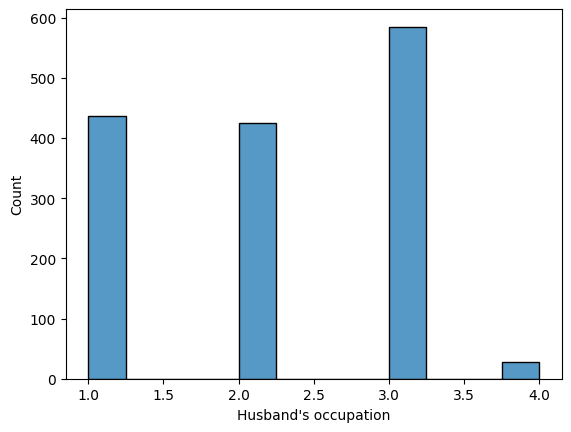

In [5]:
sns.histplot(df, x="Husband's occupation")

AttributeError: QuadMesh.set() got an unexpected keyword argument 'x'

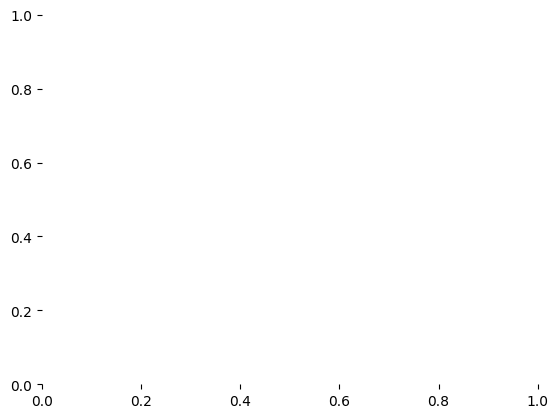

In [7]:
sns.heatmap(x = "Husband's occupation", y = "Contraceptive method used", data = df)

Modeling (5 points total)

    The implementation of logistic regression must be written only from the examples given to you by the instructor. No credit will be assigned to teams that copy implementations from another source, regardless of if the code is properly cited.
    [2 points] Create a custom, one-versus-all logistic regression classifier using numpy and scipy to optimize. Use object oriented conventions identical to scikit-learn. You should start with the template developed by the instructor in the course. You should add the following functionality to the logistic regression classifier:
        Ability to choose optimization technique when class is instantiated: either steepest ascent, stochastic gradient ascent, and {Newton's method/Quasi Newton methods}.
        Update the gradient calculation to include a customizable regularization term (either using no regularization, L1 regularization, L2 regularization, or both L1 and L2 regularization). Associate a cost with the regularization term, "C", that can be adjusted when the class is instantiated.
    [1.5 points] Train your classifier to achieve good generalization performance. That is, adjust the optimization technique and the value of the regularization term(s) "C" to achieve the best performance on your test set. Visualize the performance of the classifier versus the parameters you investigated. Is your method of selecting parameters justified? That is, do you think there is any "data snooping" involved with this method of selecting parameters?
    [1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results.


Deployment (1 points total)

        Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party)? Why?


Exceptional Work (1 points total)

    You have free reign to provide additional analyses. One idea: Update the code to use either "one-versus-all" or "one-versus-one" extensions of binary to multi-class classification.
    Required for 7000 level students: Choose ONE of the following:
        Option One: Implement an optimization technique for logistic regression using mean square error as your objective function (instead of maximum likelihood). Derive the gradient updates for the Hessian and use Newton's method to update the values of "w". Then answer, which process do you prefer: maximum likelihood OR minimum mean-squared error?